### Setup

In [72]:
# Path
import os
from os.path import isdir, join
from pathlib import Path

# Scientific Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split

# Visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.offline as py
import plotly.graph_objs as go

# Keras
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv1D, Conv2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import Model

# Miscellaneous
import random
import copy
import librosa
from librosa import display

%matplotlib inline

### Import Data

In [5]:
train_audio_path = '/home/ubuntu/data/speech_commands/'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.remove("_background_noise_")
dirs.sort()
print('Number of labels: {l}'.format(l=len(dirs)))
print(dirs)

Number of labels: 35
['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']
unknown_list = [d for d in dirs if d not in target_list]

In [7]:
label = 0
sample_rate = 8000

wav_all = [] # data for every wav in the dataset (ordered)
label_all = [] # list of all labels of dataset (ordered)
label_value = {"unknown" : 0} # { label_str : number }

for direct in dirs:
    
    if direct in target_list:
        label += 1
        label_value[direct] = label
        
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    
    for wav in waves:
        samples, _ = librosa.load(join(join(train_audio_path,direct),wav), sr = sample_rate)
        if samples.shape[0] == sample_rate: # checks sample size
            wav_all.append(samples)
            tag = direct
            if direct in unknown_list:
                tag = "unknown"
            label_all.append(label_value[tag])

In [8]:
for tag in range(len(target_list) + 1):
    print("{i}: {c}".format(i=tag, c=label_all.count(tag)))

0: 60419
1: 3580
2: 3478
3: 3502
4: 3545
5: 3427
6: 3471
7: 3448
8: 3563
9: 3269
10: 3692


In [9]:
wav_vals = np.array([x for x in wav_all])
label_vals = keras.utils.to_categorical(np.array([x for x in label_all]), len(label_value))

In [10]:
print(wav_vals.shape)
print(label_vals.shape)

(95394, 8000)
(95394, 11)


In [ ]:
# frees RAM from setup
del wav_all[:]
del wav_all
del label_all[:]
del label_all

In [11]:
train_wav, test_wav, train_label, test_label = train_test_split(wav_vals, label_vals, test_size=0.2, random_state = 2019, shuffle=True)

In [12]:
print(train_wav.shape)
print(len(train_label))
print(test_wav.shape)
print(len(test_label))

(76315, 8000)
76315
(19079, 8000)
19079


### 1D Convolutional Network

In [73]:
# Parameters
generations = 20000
num_gens_to_wait = 250
batch_size = 512
drop_out_rate = 0.5
input_shape = (sample_rate,1)

In [74]:
#For Conv1D add Channel
train_wav = train_wav.reshape(-1, sample_rate, 1)
test_wav = test_wav.reshape(-1, sample_rate, 1)

In [75]:
# Verify all dimensions
print('Train_Wav Demension : ' + str(np.shape(train_wav)))
print('Train_Label Demension : ' + str(np.shape(train_label)))
print('Test_Wav Demension : ' + str(np.shape(test_wav)))
print('Test_Label Demension : ' + str(np.shape(test_label)))
print('Number Of Labels : ' + str(len(label_value)))

Train_Wav Demension : (76315, 8000, 1)
Train_Label Demension : (76315, 11)
Test_Wav Demension : (19079, 8000, 1)
Test_Label Demension : (19079, 11)
Number Of Labels : 11


In [76]:
conv1d = Sequential()
conv1d.add(Conv1D(8, 5, padding='same', activation='relu', strides=1, input_shape = input_shape))
conv1d.add(MaxPooling1D(pool_size=(2)))
conv1d.add(Dropout(.5))
conv1d.add(Conv1D(16, 3, padding='same', activation='relu', strides=1))
conv1d.add(MaxPooling1D(pool_size=(2)))
conv1d.add(Dropout(.5))
conv1d.add(Conv1D(32, 5, padding='same', activation='relu', strides=1))
conv1d.add(MaxPooling1D(pool_size=(2)))
conv1d.add(Dropout(.5))
conv1d.add(Conv1D(64, 4, padding='same', activation='relu', strides=1))
conv1d.add(MaxPooling1D(pool_size=(2)))
conv1d.add(Dropout(.5))
conv1d.add(Conv1D(128, 3, padding='same',activation='relu', strides=1))
conv1d.add(MaxPooling1D(pool_size=(2)))
conv1d.add(Flatten())
conv1d.add(Dense(128, activation = 'relu'))
conv1d.add(Dropout(.5))
conv1d.add(Dense(11))
conv1d.add(Activation('softmax'))

cn_opt = keras.optimizers.Adam(lr=0.001)
conv1d.compile(loss=keras.losses.categorical_crossentropy, optimizer=cn_opt, metrics=['accuracy'])

In [78]:
conv1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8000, 8)           48        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4000, 8)           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4000, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 16)          400       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2000, 16)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 2000, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2000, 32)          2592      
__________

### Train 1D Conv on Raw WAV

In [80]:
cn_history = conv1d.fit(train_wav, train_label, validation_data=[test_wav, test_label], batch_size=batch_size, epochs=100, verbose=1)

Train on 76315 samples, validate on 19079 samples
Epoch 1/100
76315/76315 [==============================] - 11s 147us/step - loss: 1.5734 - acc: 0.6284 - val_loss: 1.5773 - val_acc: 0.6374
Epoch 2/100
76315/76315 [==============================] - 9s 119us/step - loss: 1.4563 - acc: 0.6324 - val_loss: 1.4588 - val_acc: 0.6374
Epoch 3/100
76315/76315 [==============================] - 9s 119us/step - loss: 1.3477 - acc: 0.6335 - val_loss: 1.4258 - val_acc: 0.6441
Epoch 4/100
76315/76315 [==============================] - 9s 118us/step - loss: 1.2712 - acc: 0.6378 - val_loss: 1.3432 - val_acc: 0.6365
Epoch 5/100
76315/76315 [==============================] - 9s 118us/step - loss: 1.2197 - acc: 0.6428 - val_loss: 1.3390 - val_acc: 0.6521
Epoch 6/100
76315/76315 [==============================] - 9s 118us/step - loss: 1.1762 - acc: 0.6456 - val_loss: 1.2048 - val_acc: 0.6576
Epoch 7/100
76315/76315 [==============================] - 9s 119us/step - loss: 1.1285 - acc: 0.6523 - val_loss: 1

76315/76315 [==============================] - 9s 118us/step - loss: 0.5832 - acc: 0.7918 - val_loss: 0.7050 - val_acc: 0.7979
Epoch 60/100
76315/76315 [==============================] - 9s 118us/step - loss: 0.5819 - acc: 0.7934 - val_loss: 0.7119 - val_acc: 0.7947
Epoch 61/100
76315/76315 [==============================] - 9s 119us/step - loss: 0.5725 - acc: 0.7961 - val_loss: 0.6997 - val_acc: 0.7940
Epoch 62/100
76315/76315 [==============================] - 9s 118us/step - loss: 0.5711 - acc: 0.7963 - val_loss: 0.6538 - val_acc: 0.8055
Epoch 63/100
76315/76315 [==============================] - 9s 119us/step - loss: 0.5670 - acc: 0.7982 - val_loss: 0.7363 - val_acc: 0.7896
Epoch 64/100
76315/76315 [==============================] - 9s 119us/step - loss: 0.5620 - acc: 0.7975 - val_loss: 0.7149 - val_acc: 0.7928
Epoch 65/100
76315/76315 [==============================] - 9s 119us/step - loss: 0.5735 - acc: 0.7956 - val_loss: 0.6949 - val_acc: 0.7983
Epoch 66/100
76315/76315 [=======

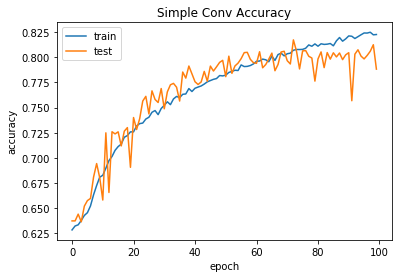

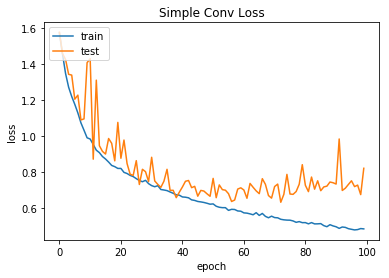

In [81]:
plt.rcParams['figure.figsize'] = (6,4)

# summarize cn_history for accuracy
plt.plot(cn_history.history['acc'])
plt.plot(cn_history.history['val_acc'])
plt.title('Simple Conv Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize cn_history for loss
plt.plot(cn_history.history['loss'])
plt.plot(cn_history.history['val_loss'])
plt.title('Simple Conv Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 2D LeNet5 Network on MFCC

In [51]:
mfccs1 = librosa.feature.mfcc(wav_vals[25], 8000)
mfccs2 = librosa.feature.melspectrogram(wav_vals[150], 8000)
print(mfccs1.shape)
print(mfccs2.shape)

(20, 16)
(128, 16)


In [48]:
def mfcc(row):
    """
    input - 1d row of wav_vals array
    output - 2d array of mfcc coefficients
    """
    return librosa.feature.mfcc(row, 8000)

mfcc_array = np.apply_along_axis(mfcc, axis=1, arr = wav_vals)
print(mfcc_array.shape)

(95394, 20, 16)


In [54]:
Xtrain_ln5, Xtest_ln5, Ytrain_ln5, Ytest_ln5 = train_test_split(mfcc_array, label_vals, test_size=0.2, random_state = 2019, shuffle=True)

In [55]:
Xtrain_ln5 = Xtrain_ln5[..., np.newaxis]
Xtest_ln5 = Xtest_ln5[..., np.newaxis]

print("Xtrain_ln5.shape:", Xtrain_ln5.shape)
print("Xtest_ln5.shape:", Xtest_ln5.shape)
print("Ytrain_ln5.shape:", Ytrain_ln5.shape)
print("Ytest_ln5.shape:", Ytest_ln5.shape)

('Xtrain_ln5.shape:', (76315, 20, 16, 1))
('Xtest_ln5.shape:', (19079, 20, 16, 1))
('Ytrain_ln5.shape:', (76315, 11))
('Ytest_ln5.shape:', (19079, 11))


In [62]:
lenet5 = Sequential()
lenet5.add(Conv2D(32, (5,5), padding = 'same', input_shape = Xtrain_ln5.shape[1:]))
lenet5.add(Activation('relu'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))
lenet5.add(Conv2D(64, (5, 5), padding='same'))
lenet5.add(Activation('relu'))
lenet5.add(MaxPooling2D(pool_size=(2, 2)))
lenet5.add(Flatten())
lenet5.add(Dense(1024))
lenet5.add(Activation('relu'))
lenet5.add(Dropout(0.5))
lenet5.add(Dense(11))
lenet5.add(Activation('softmax'))

# ln_opt = keras.optimizers.Adam(lr=0.0001)
ln_opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
lenet5.compile(loss='categorical_crossentropy', optimizer=ln_opt, metrics=['accuracy'])

In [63]:
lenet5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 20, 16, 32)        832       
_________________________________________________________________
activation_17 (Activation)   (None, 20, 16, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 10, 8, 32)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 8, 64)         51264     
_________________________________________________________________
activation_18 (Activation)   (None, 10, 8, 64)         0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 4, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1280)              0         
__________

### Train 2D LeNet5 

In [64]:
ln_history = lenet5.fit(Xtrain_ln5, Ytrain_ln5, batch_size=512, epochs=100, validation_data=(Xtest_ln5, Ytest_ln5), shuffle=True)

Train on 76315 samples, validate on 19079 samples
Epoch 1/100
76315/76315 [==============================] - 2s 24us/step - loss: 5.9927 - acc: 0.6269 - val_loss: 5.8443 - val_acc: 0.6374
Epoch 2/100
76315/76315 [==============================] - 1s 12us/step - loss: 4.9544 - acc: 0.5887 - val_loss: 1.3051 - val_acc: 0.6254
Epoch 3/100
76315/76315 [==============================] - 1s 12us/step - loss: 1.1649 - acc: 0.6578 - val_loss: 0.8937 - val_acc: 0.7193
Epoch 4/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.8161 - acc: 0.7386 - val_loss: 0.6921 - val_acc: 0.7799
Epoch 5/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.6708 - acc: 0.7833 - val_loss: 0.6396 - val_acc: 0.7864
Epoch 6/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.5796 - acc: 0.8099 - val_loss: 0.5550 - val_acc: 0.8150
Epoch 7/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.5151 - acc: 0.8312 - val_loss: 0.4803 - 

76315/76315 [==============================] - 1s 12us/step - loss: 0.0375 - acc: 0.9882 - val_loss: 0.4387 - val_acc: 0.9118
Epoch 60/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0373 - acc: 0.9877 - val_loss: 0.3321 - val_acc: 0.9221
Epoch 61/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0345 - acc: 0.9888 - val_loss: 0.3401 - val_acc: 0.9204
Epoch 62/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0360 - acc: 0.9881 - val_loss: 0.3052 - val_acc: 0.9255
Epoch 63/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0333 - acc: 0.9892 - val_loss: 0.3121 - val_acc: 0.9248
Epoch 64/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0327 - acc: 0.9896 - val_loss: 0.3595 - val_acc: 0.9184
Epoch 65/100
76315/76315 [==============================] - 1s 12us/step - loss: 0.0317 - acc: 0.9897 - val_loss: 0.3728 - val_acc: 0.9180
Epoch 66/100
76315/76315 [==============

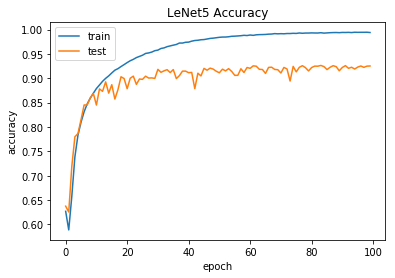

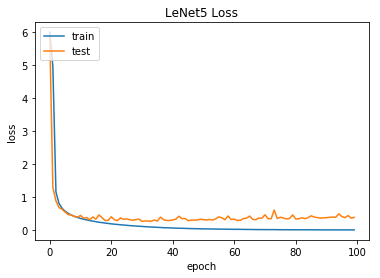

In [70]:
plt.rcParams['figure.figsize'] = (6,4)

# summarize ln_history for accuracy
plt.plot(ln_history.history['acc'])
plt.plot(ln_history.history['val_acc'])
plt.title('LeNet5 Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize ln_history for loss
plt.plot(ln_history.history['loss'])
plt.plot(ln_history.history['val_loss'])
plt.title('LeNet5 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Spectrograms

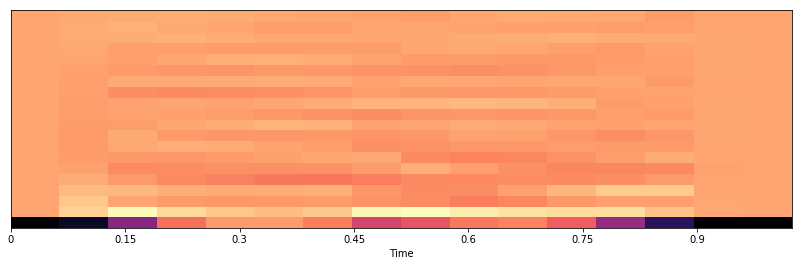

In [52]:
plt.rcParams['figure.figsize'] = (14,4)
display.specshow(mfccs1, sr = 8000, x_axis='time', cmap = cm.magma)

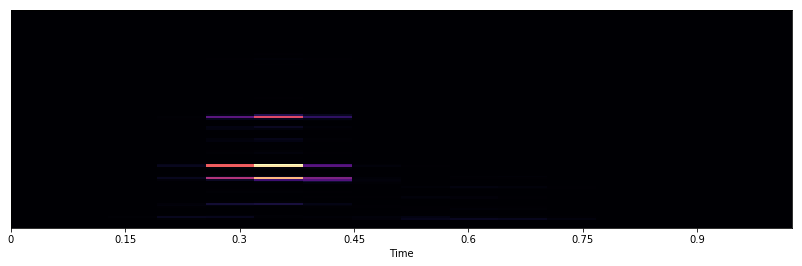

In [53]:
display.specshow(mfccs2, sr = 8000, x_axis='time', cmap = cm.magma)

### Automated Censorship

For the task of automated censorship, we needed to isolate the individual words for predictions in our models. While we explored writing custom algorithms to split on the valleys times in the noise data, ultimately (based on time considerations) we implemented Google Clouds' speech-to-text API to timestamp and then used the librosa library to cut out and pad words. The exported wav files can be fed directly into either of our models with minimal preprocessing.

In [ ]:
import os
import io
import numpy as np
import librosa
from google.cloud import speech_v1

def convert(path):
    for filename in os.listdir(path):
        if (filename.endswith(".m4a")):
            # ffmpeg -i 001.m4a -ar 8000 -ac 1 001.wav
            os.system("ffmpeg -i {} -ar 8000 -ac 1 %03d.wav".format(filename))

def timestamp(local_file_path, sample_rate, raw):

    client = speech_v1.SpeechClient()
    config = { "enable_word_time_offsets": True, "language_code": "en-US",
                "sample_rate_hertz": sample_rate }

    with io.open(local_file_path, "rb") as f:
        content = f.read()
    audio = {"content": content}

    operation = client.long_running_recognize(config, audio)
    print(u"Waiting for operation to complete...")
    response = operation.result()
    alternative = result.alternatives[0]

    words = []
    kilohertz = 1.0 / sample_rate
    for word in alternative:
        start = int(word.start_time.seconds + (1e-9 * word.start_time.nanos) / kilohertz)
        finish = int(word.end_time.seconds + (1e-9 * word.end_time.nanos) / kilohertz)
        words.append(raw[start:finish])
    return words

def process(words, sr):
    new_words = []
    for word in words:
        diff = sr - word.shape[0]
        if diff > 0:
            silence = np.full(diff, -16)
            new = word.hstack((silence))
            new_words.append(new)
        elif diff == 0:
            new_words.append(word)
    return new_words

def export(directory, words, sr):
    for word in words:
        librosa.soundfile.write(directory + "%03d.wav", word, sr)

filename = "001.wav"
raw, sr = librosa.load(filename, sr=8000)
words = timestamp(filename, sr, raw)
processed = process(words)
export(processed)

After runnning this script to isolate the words, we can feed the wav through the model. If the model determines them to be a keyword, we can use librosa to replace the time with a beep wav file of the same frequency and time length.